In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.linalg as sp
import scipy.stats as ss
random.seed(1)

### Generating State space model for reactor:

In [4]:
W = 2104.7 # in kg

X00 = np.array([0.0874, 0.3896, 0.0153, 0.2907, 0.1075, 0.1095])

P00 = np.identity(6, dtype = float)  # Initial Covariance Estimate

R = np.identity(4, dtype = float)    # Measurement Noise Covariance Matrix at Ts=30 
R[0][0] = (0.00389)**2
R[1][1] = (0.00015)**2
R[2][2] = (0.0029)**2
R[3][3] = (0.0011)**2

Q = np.identity(6, dtype = float)    # State Noise Covariance Matrix
Q[0][0] = (0.00044)**2
Q[1][1] = (0.0019)**2
Q[2][2] = (0.00008)**2
Q[3][3] = (0.0014)**2
Q[4][4] = (0.00053)**2
Q[5][5] = (0.00054)**2

Ns = 1900

timestep = 30

Fa = 1.8270 # in kg/s

b1 = 1.6599 * 10**6

b2 = 7.2117 * 10**8

b3 = 2.6745 * 10**12

### Creating a class for reactor

In [5]:
from math import exp
class ottoReactor(object):
    
    def __init__(self, Tr):  
        
        #The states:
        self.xa = 0.0874
        self.xb = 0.3896
        self.xc = 0.0153
        self.xe = 0.2907
        self.xg = 0.1075
        self.xp = 0.1095
        
        #The reaction constants:
        self.k1 = b1 * exp(-6666.7/Tr)
        self.k2 = b2 * exp(-8333.3/Tr)
        self.k3 = b3 * exp(-11111/Tr)
        
        #The reaction rates:
        self.r1 = self.k1*self.xa*self.xb*W 
        self.r2 = self.k2*self.xb*self.xc*W
        self.r3 = self.k3*self.xc*self.xp*W
        
        #Differentiation of rates w.r.t Tr of 11.2:
        self.dr1 = self.xa*self.xb*W*self.r1*6666.7/Tr**2
        self.dr2 = self.xb*self.xc*W*self.r2*8333.3/Tr**2
        self.dr3 = self.xc*self.xp*W*self.r3*11111/Tr**2
        
    #Setting state from input TO class:
    def setState(self, X):
        self.xa=X[0]
        self.xb=X[1]
        self.xc=X[2]
        self.xe=X[3]
        self.xg=X[4]
        self.xp=X[5]

    #Obtaining current state FROM class:
    def getState(self):
        return np.array([self.xa, self.xb, self.xc, self.xe, self.xg, self.xp])
    
    #The differentiating equations (11.2a, 11.2b, 11.2c, 11.2d, 11.2e, 11.2f):
    def dxdt(self, Fb):
        
        dxadt = (Fa - (Fa + Fb)*self.xa - self.r1)/W
        dxbdt = (Fa - (Fa + Fb)*self.xb - self.r1 - self.r2)/W
        dxcdt = (-(Fa + Fb)*self.xc + 2*self.r1 - 2*self.r2 - self.r3)/W
        dxedt = (-(Fa + Fb)*self.xe + 2*self.r2)/W
        dxgdt = (-(Fa + Fb)*self.xg + 1.5*self.r3)/W
        dxpdt = (-(Fa + Fb)*self.xp + self.r2 - 0.5*self.r3)/W
        
        A = np.array([dxadt, dxbdt, dxcdt, dxedt, dxgdt, dxpdt])
        
        return A
    
    #Euler method to update states:
    def euler(self, timestep, Fb, Tr, noise=False):
        
        X=self.getState()
        X+=timestep*self.dxdt(Fb)
        if noise==True:
            X+=np.random.multivariate_normal([0, 0, 0, 0, 0, 0], Q)
        self.setState(X)
        
    def Jacobian(self, Fb):
        
        X=self.getState()
        xa=X[0]
        xb=X[1]
        xc=X[2]
        xe=X[3]
        xg=X[4]
        xp=X[5]
        
        j1 = np.array([-(Fa+Fb) - self.k1*xb*W, -self.k1*xa*W, 0, 0, 0, 0])/W
        j2 = np.array([(-self.k1*xb*W), (-(Fa+Fb) - self.k1*xa*W - self.k2*xc*W), (-self.k2*xb*W), 0,0,0])/W
        j3 = np.array([(2*self.k1*xb*W), (2*self.k1*xa*W - 2*self.k2*xc*W), (-Fa-Fb-2*self.k2*xb*W-self.k3*xp*W), 0,0, (-self.k3*xc*W)])/W
        j4 = np.array([0,2*self.k2*xc*W, 2*self.k2*xb*W, -Fa-Fb, 0,0])/W
        j5 = np.array([0,0, 1.5*self.k3*xp*W, 0, -Fa-Fb, 1.5*self.k3*xc*W])/W
        j6 = np.array([0,0, self.k2*xb*W - 0.5*self.k3*xp*W, 0,0, -Fa-Fb-0.5*self.k3*xc*W])/W
        
        j = np.array([j1, j2, j3, j4, j5, j6])
        
        A = -np.array([xa,xb,xc,xe,xg,xp])
        
        B = np.array([-self.dr1, -self.dr1-self.dr2, 2*self.dr1 - 2*self.dr2 - self.dr3, 2*self.dr2, 1.5*self.dr3, self.dr2-0.5*self.dr3])
        
        A = np.array([A,B])
        
        return j, A
    
    def y_measure(self, noise=False):
        
        c = np.zeros((4,6), dtype = float)
        c[0][1] = 1
        c[1][2] = 1
        c[2][4] = 1
        c[3][5] = 1
        
        Y=np.dot(c, self.getState())
        
        if noise:
            
            Y+=np.random.multivariate_normal([0, 0, 0, 0], R)
        
        return Y
    
    def del_y(self):
        
        c = np.zeros((4,6), dtype = float)
        c[0][1] = 1
        c[1][2] = 1
        c[2][4] = 1
        c[3][5] = 1
        
        return c

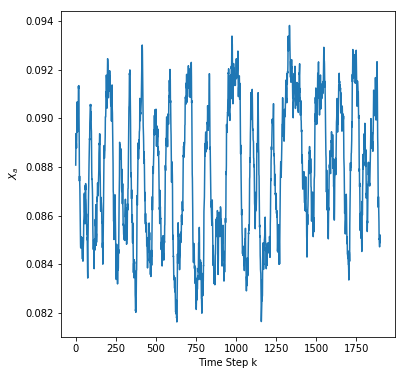

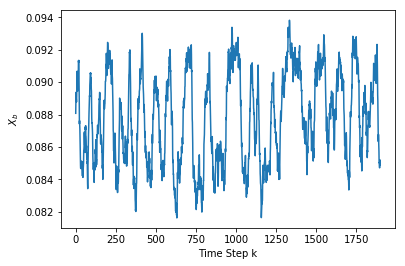

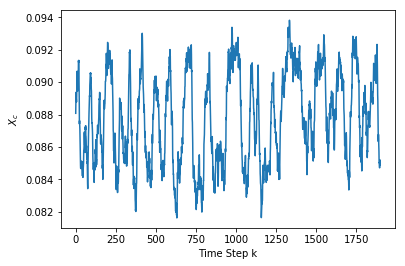

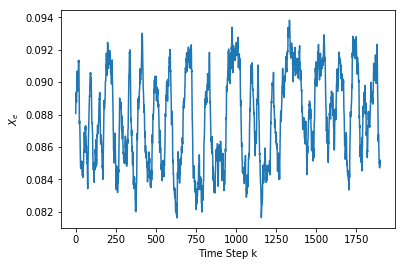

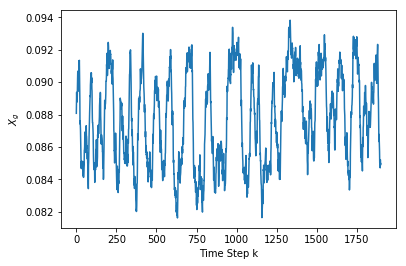

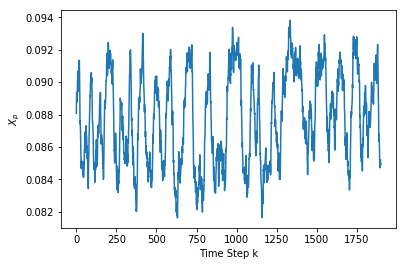

In [6]:
a = ottoReactor(362.85)

X = a.getState()
Xall = []
Fb = 4.789
Tr = 362.85
Y_pred = []

# Defining perturbation inputs:

S1=[]
S2=[]
for i in range(100):
    
    bit1=random.choice([-0.2394, 0.2394])
    bit2=random.choice([-4.485, 4.485])
    for j in range(19):
        S1.append(4.789+bit1)
        S2.append(362.85+bit2)
        

for i in range(0, 1900):
    Fb=S1[i]
    Tr=S2[i]
    a.euler(timestep, Fb, Tr, True)
    X=a.getState()
    Xall.append(X)
    y=a.y_measure(True)
    Y_pred.append(y)

Xall=np.array(Xall)
Y_pred=np.array(Y_pred)

plt.figure(figsize = (6,6))

plt.plot(Xall[:, 0])
plt.ylabel('$X_a$')
plt.xlabel('Time Step k')
plt.show()
plt.plot(Xall[:, 0])
plt.ylabel('$X_b$')
plt.xlabel('Time Step k')
plt.show()
plt.plot(Xall[:, 0])
plt.ylabel('$X_c$')
plt.xlabel('Time Step k')
plt.show()
plt.plot(Xall[:, 0])
plt.ylabel('$X_e$')
plt.xlabel('Time Step k')
plt.show()
plt.plot(Xall[:, 0])
plt.ylabel('$X_g$')
plt.xlabel('Time Step k')
plt.show()
plt.plot(Xall[:, 0])
plt.ylabel('$X_p$')
plt.xlabel('Time Step k')
plt.show()

### Generating Perturbed Inputs:

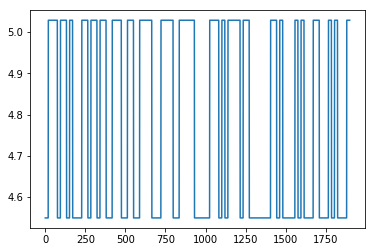

In [7]:
plt.plot(S1) #Fb

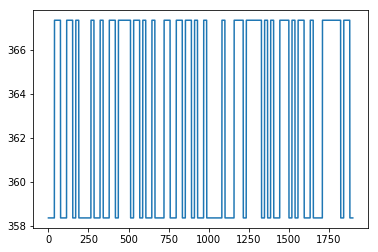

In [9]:
plt.plot(S2) #Tr

In [10]:
b=ottoReactor(Tr)
Fb=4.789
Tr=362.85
for i in range(0, 1900):
    b.euler(timestep, Fb, Tr, False)
    
x_steady = b.getState()
E_x = []
A, C = b.Jacobian(Fb)

### KALMAN FILTER

In [478]:
Phi=np.identity(6)+A*30
Tau=30*C
T=30
C = b.del_y()

r=ottoReactor(Tr)
X0=x_steady
P0=P00

Xstore=[]
ee=[]      #Measurement Error
E_x=[]     #Actual Error
Bk=[]      #Bk     
Rp=[]      #Predicted spectral radii
Ru=[]      #Updated spectral radii

X_est=X0
Cov_est_meas=P0

E=[]  

for i in range(0, 1900):
    
    Fb=U1[i]
    Tr=U2[i]
    #initial estimates
    r.setState(X_est)
    X_est+=T*r.dxdt(Fb)
    Cov_est_meas=np.linalg.multi_dot([Phi, Cov_est_meas, np.transpose(Phi)])+Q
    Max_eigen, eigenvector=np.linalg.eig(Cov_est_meas)
    Rp.append(max(Max_eigen))
    
    
    #Compute Kalman Gain Matrix
    t1=np.linalg.multi_dot([C, Cov_est_meas, np.transpose(C)])+R
    t1=np.linalg.inv(t1)
    L=np.linalg.multi_dot([Cov_est_meas, np.transpose(C), t1])
    #L=L*0
    
    #Compute Innovation
    e=Ysim[i]-np.dot(C, X_est)
    ee.append(e)
    
    #Update Estimates
    X_est=X_est+np.dot(L, e)
    t1=np.identity(6)-np.dot(L, C)
    Cov_est_meas=np.dot(t1, Cov_est_meas)
    
    Max_eigen, eigenvector=np.linalg.eig(Cov_est_meas)
    Ru.append(max(Max_eigen))
    
    #Storing estimated results
    Xstore.append(X_est)
    e_x=Xall[i]-X_est
    E_x.append(e_x)
    Pinverse=sp.inv(Cov_est_meas)
    
    bk=np.dot(e_x, np.dot(Pinverse, e_x))
    Bk.append(bk)

In [479]:
E_x_kf=np.array(E_x)
bk_kf = np.array(Bk)
ee_kf=np.array(ee)
Rp_kf = np.array(Rp)
Ru_kf = np.array(Ru)
Xstore_kf=np.array(Xstore)

print(bk_kf)

[  7.5031968   14.06739419  13.76958975 ... 313.63731891 378.56112936
 358.96381808]


In [480]:
def IMlin(x, z):
    
    S=ottoReactor()
    S.setState(x)
    A, B=S.Jacobian(z)
    
    C=np.identity(6)
    return A, B, C

# Extended Kalman Filter

In [481]:
b=ottoReactor(Tr)

    
x_steady = b.getState()
E_x = []

In [497]:
T=30

r=ottoReactor(362.85)
X0=x_steady
P0=P00

Xstore=[]
ee=[]      #Measurement Error
E_x=[]     #Actual Error
Bk=[]      #Bk     
Rp=[]      #Spectral Radii-Predicted
Ru=[]      #Spectral Radii-Updated

X_est=X0
P_cov_est=P0

E=[]  

for i in range(0, 1900):
    
    r.setState(X_est)
    A, C = r.Jacobian(Fb)
    Phi=sp.expm(A*30) 
    Tau=30*C

    C = r.del_y()
    
    Fb=U1[i]
    Tr=U2[i]
    r.setState(X_est)
    X_est+=T*r.dxdt(Fb)
    P_cov_est=np.linalg.multi_dot([Phi, P_cov_est, np.transpose(Phi)])+Q
    Max_eigen, eigenvector=np.linalg.eig(P_cov_est)
    Rp.append(max(Max_eigen))
    
    #Kalman Gain Matrix
    t1=np.linalg.multi_dot([C, P_cov_est, np.transpose(C)])+R
    t1=np.linalg.inv(t1)
    L=np.linalg.multi_dot([P_cov_est, np.transpose(C), t1])
    
    #Innovation
    e=Ysim[i]-np.dot(C, X_est)
    ee.append(e)
    
    #Update Estimates
    X_est=X_est+np.dot(L, e)
    t1=np.identity(6)-np.dot(L, C)
    P_cov_est=np.dot(t1, P_cov_est)
    
    Max_eigen, eigenvector=np.linalg.eig(P_cov_est)
    Ru.append(max(Max_eigen))
    
    #estimated results
    Xstore.append(X_est)
    e_x=Xall[i]-X_est
    E_x.append(e_x)
    Pinverse=sp.inv(P_cov_est)
    
    bk=np.dot(e_x, np.dot(Pinverse, e_x))
    Bk.append(bk)

In [498]:
E_x_ekf = np.array(E_x)
ee_ekf = np.array(ee)
bk_ekf = np.array(Bk)
Rp_ekf = np.array(Rp)
Ru_ekf = np.array(Ru)
Xstore_ekf = np.array(Xstore)
Xall_ekf = np.array(Xall)

### Predicted and Actual States plot

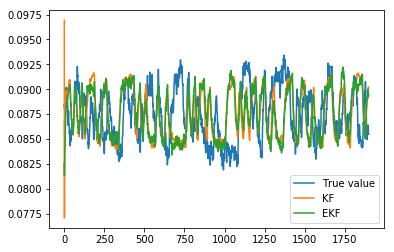

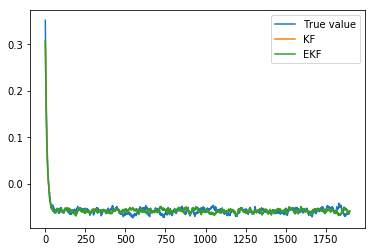

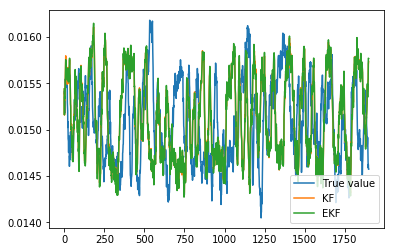

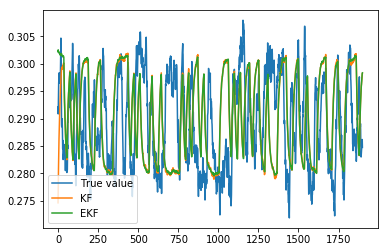

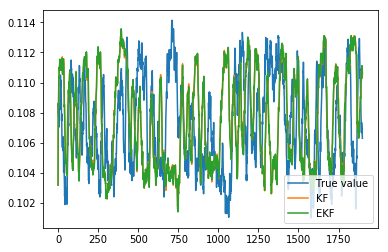

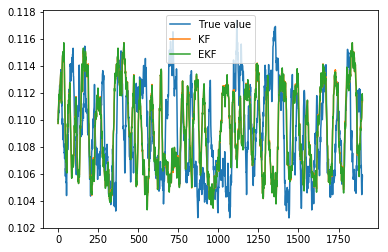

In [499]:
plt.plot(Xall[:,0])
plt.plot(Xstore_kf[:,0])
plt.plot(Xstore_ekf[:,0])
plt.legend(['True value', 'KF', 'EKF'])
plt.show()

plt.plot(Xall[:,1])
plt.plot(Xstore_kf[:,1])
plt.plot(Xstore_ekf[:,1])
plt.legend(['True value', 'KF', 'EKF'])
plt.show()

plt.plot(Xall[:,2])
plt.plot(Xstore_kf[:,2])
plt.plot(Xstore_ekf[:,2])
plt.legend(['True value', 'KF', 'EKF'])
plt.show()

plt.plot(Xall[:,3])
plt.plot(Xstore_kf[:,3])
plt.plot(Xstore_ekf[:,3])
plt.legend(['True value', 'KF', 'EKF'])
plt.show()

plt.plot(Xall[:,4])
plt.plot(Xstore_kf[:,4])
plt.plot(Xstore_ekf[:,4])
plt.legend(['True value', 'KF', 'EKF'])
plt.show()

plt.plot(Xall[:,5])
plt.plot(Xstore_kf[:,5])
plt.plot(Xstore_ekf[:,5])
plt.legend(['True value', 'KF', 'EKF'])
plt.show()

### Innovation Plot

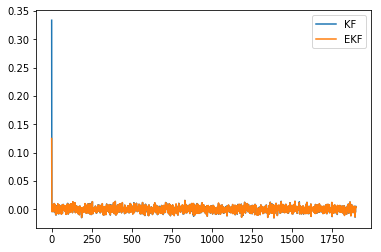

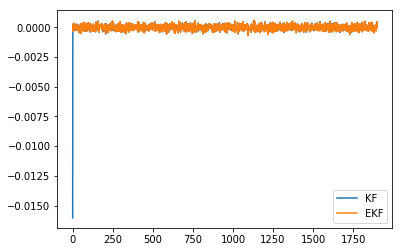

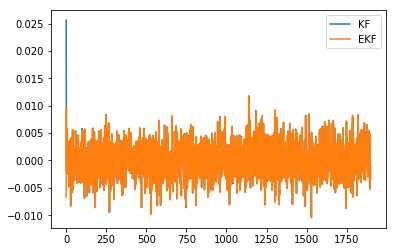

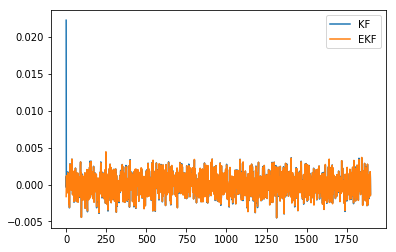

In [500]:
plt.plot(ee_kf[:,0])
plt.plot(ee_ekf[:,0])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(ee_kf[:,1])
plt.plot(ee_ekf[:,1])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(ee_kf[:,2])
plt.plot(ee_ekf[:,2])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(ee_kf[:,3])
plt.plot(ee_ekf[:,3])
plt.legend(['KF', 'EKF'])
plt.show()

### Estimation error: xtrue - xest

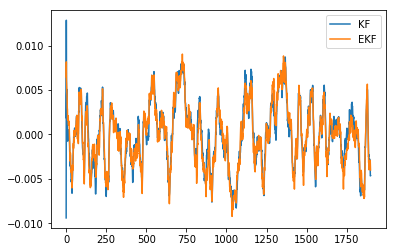

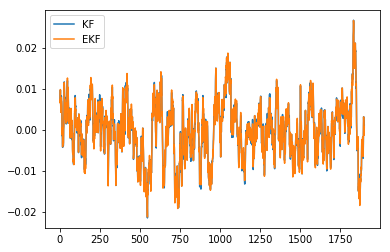

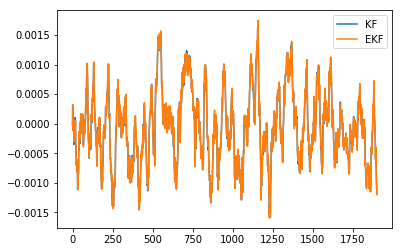

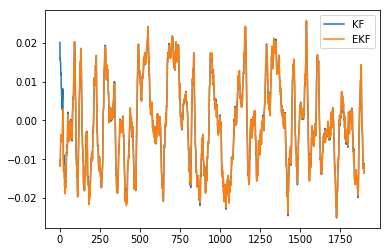

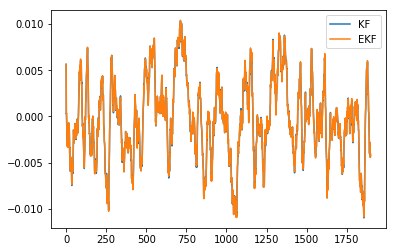

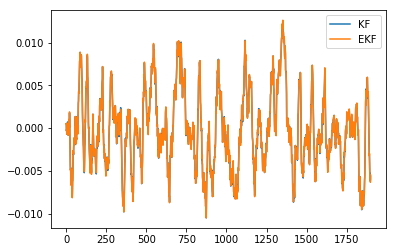

In [501]:
plt.plot(E_x_kf[:,0])
plt.plot(E_x_ekf[:,0])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(E_x_kf[:,1])
plt.plot(E_x_ekf[:,1])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(E_x_kf[:,2])
plt.plot(E_x_ekf[:,2])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(E_x_kf[:,3])
plt.plot(E_x_ekf[:,3])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(E_x_kf[:,4])
plt.plot(E_x_ekf[:,4])
plt.legend(['KF', 'EKF'])
plt.show()

plt.plot(E_x_kf[:,5])
plt.plot(E_x_ekf[:,5])
plt.legend(['KF', 'EKF'])
plt.show()

### spectral radii for kf

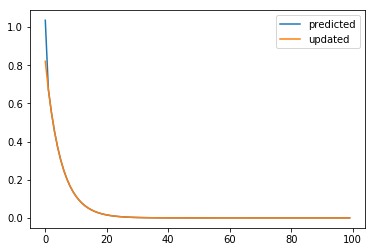

In [502]:
plt.plot(Rp_kf[0:100])
plt.plot(Ru_kf[0:100])
plt.legend(['predicted', 'updated'])
plt.show()

### spectral radii for EKF: max(abs(cov matrix)) eigen values

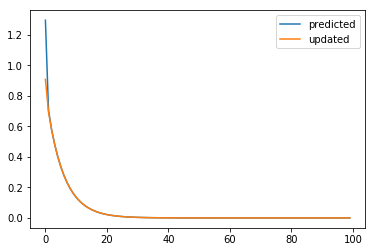

In [508]:
plt.plot(Rp_ekf[0:100])
plt.plot(Ru_ekf[0:100])
plt.legend(['predicted', 'updated'])
plt.show()

### RMSE

In [509]:
print('S.D. of estimation error for xa with KF is: ')
print(np.std(E_x_kf[:, 0]))
print()

print('S.D. of estimation error for xb with KF is: ')
print(np.std(E_x_kf[:, 1]))
print()

print('S.D. of estimation error for xc with KF is: ')
print(np.std(E_x_kf[:, 2]))
print()

print('S.D. of estimation error for xe with KF is: ')
print(np.std(E_x_kf[:, 3]))
print()

print('S.D. of estimation error for xg with KF is: ')
print(np.std(E_x_kf[:, 4]))
print()

print('S.D. of estimation error for xp with KF is: ')
print(np.std(E_x_kf[:, 5]))
print()

S.D. of estimation error for xa with KF is: 
0.0034409717151247378

S.D. of estimation error for xb with KF is: 
0.006671603108678594

S.D. of estimation error for xc with KF is: 
0.0005963658893964952

S.D. of estimation error for xe with KF is: 
0.010977083212085703

S.D. of estimation error for xg with KF is: 
0.004181228155476533

S.D. of estimation error for xp with KF is: 
0.004372030162303557



In [510]:
print('S.D. of estimation error for xa with EKF is: ')
print(np.std(E_x_ekf[:, 0]))
print()

print('S.D. of estimation error for xb with EKF is: ')
print(np.std(E_x_ekf[:, 1]))
print()

print('S.D. of estimation error for xc with EKF is: ')
print(np.std(E_x_ekf[:, 2]))
print()

print('S.D. of estimation error for xe with EKF is: ')
print(np.std(E_x_ekf[:, 3]))
print()

print('S.D. of estimation error for xg with EKF is: ')
print(np.std(E_x_ekf[:, 4]))
print()

print('S.D. of estimation error for xp with EKF is: ')
print(np.std(E_x_ekf[:, 5]))
print()

S.D. of estimation error for xa with EKF is: 
0.0034905367965805886

S.D. of estimation error for xb with EKF is: 
0.00670754192860753

S.D. of estimation error for xc with EKF is: 
0.0005991488977213491

S.D. of estimation error for xe with EKF is: 
0.010934251358971638

S.D. of estimation error for xg with EKF is: 
0.004181365386089756

S.D. of estimation error for xp with EKF is: 
0.0043745444735749355



### Normalised estimation error squared

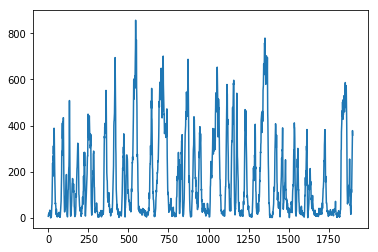

In [506]:
plt.plot(bk_kf)

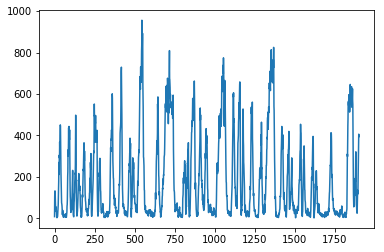

In [507]:
plt.plot(bk_ekf)